In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
import ssl
from ete3 import NCBITaxa
from io import StringIO
from matplotlib_venn import venn3

# Configure SSL settings
ssl._create_default_https_context = ssl._create_unverified_context

# Set the directory path
input_path = 'D:/PhD Work/Vijay/Data/Input_data/'
output_path = 'D:/PhD Work/Vijay/Data/Output_data/'
figure_path = 'D:/PhD Work/Vijay/Data/Figures/'

In [3]:
# Load data from CSV files
microbes_data = pd.read_csv(input_path + '1. Data_Chng2020.xlsx - Chng_2020.csv',
                            index_col='Species')

group_data = pd.read_csv(input_path + '1. Data_Chng2020.xlsx - Chng_2020_groups.csv',
                         index_col='Species')

# Load metadata from a CSV file
metadata = pd.read_csv(input_path + '1. Data_Chng2020.xlsx - Metadata.csv',
                       index_col='Illumina Library ID')

In [4]:
# Display the head of metadata for initial exploration
group_data.head()

,Major_group
Species,
Abiotrophia defectiva,Bacteria
Acetobacter unclassified,Bacteria
Achromobacter piechaudii,Bacteria
Achromobacter unclassified,Bacteria
Achromobacter xylosoxidans,Bacteria


In [5]:
# Merge 'Major_group' column from 'group_data' into 'microbes_data' based on 'Species'
merged_data = pd.merge(microbes_data, group_data, on='Species', how='left')
merged_data

,SL336366,SL336368,SL343330,SL343331,SL343333,SL343334,SL343336,SL343337,SL343339,SL343341,...,WEE379,WEE380,WEE381,WEE382,WEE384,WEE385,WEE386,WEE387,WEE388,Major_group
Species,,,,,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,0.0,0.0,0.0,0.0,0.0,0.388,0.0,0.0,0.0,0.0,...,0.000,0.0,0.578,0.0,0.129,0.777,0.518,0.0,0.0,Bacteria
Acetobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter piechaudii,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.132,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter xylosoxidans,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthomonas euvesicatoria,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.354,0.000,0.000,0.0,0.0,Bacteria
Xanthomonas fuscans,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,7.748,0.000,0.000,0.0,0.0,Bacteria
Xanthomonas oryzae,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria


In [7]:
# Count occurrences of microbes in each environment based on 'Major_group'
transposed_data = merged_data.transpose()
data_with_environment = pd.merge(transposed_data, metadata['Environment'],
                                 left_index=True, right_index=True)
filtered_data = data_with_environment[data_with_environment != 0].groupby('Environment').count().transpose().merge(group_data,
                                                                                                               left_index=True,
                                                                                                               right_index=True)
filtered_data.iloc[:, :-1] = filtered_data.iloc[:, :-1].applymap(lambda x: 1 if x != 0 else x)
grouped_data = filtered_data.groupby('Major_group').sum()
grouped_data.T

Major_group,Archaea,Bacteria,Fungi,Virus
Hospital,3,642,10,127
MetaSUB,2,350,2,26
Office,0,179,3,4


In [8]:
# Calculate average bacterial abundance by environment
abundance_dict = {}
for group in merged_data['Major_group'].unique():
    if type(group) == str:
        group_data = merged_data[merged_data['Major_group'] == group].sum(axis=0)
        group_df = pd.DataFrame(group_data, columns=['Sum Bacteria Abundance']).rename_axis("Illumina Library ID")
        new_df = pd.merge(group_df, metadata['Environment'], left_index=True, right_index=True).rename_axis("Illumina Library ID")
        average_values = new_df.groupby('Environment')['Sum Bacteria Abundance'].mean().round(2).to_list()
        abundance_dict[group] = average_values

abundance_compiled = pd.DataFrame(abundance_dict, index=metadata['Environment'].unique())
abundance_compiled = abundance_compiled.rename_axis("Environment")
abundance_compiled

,Bacteria,Virus,Fungi,Archaea
Environment,,,,
Hospital,89.15,9.65,1.08,0.01
MetaSUB,97.87,1.87,0.19,0.01
Office,99.57,0.16,0.23,0.00


In [9]:
# Select only bacteria data for box plot
bacteria_data = merged_data[merged_data['Major_group'] == "Bacteria"].sum(axis=0)
bacteria_df = pd.DataFrame(bacteria_data, columns=['Sum Bacteria Abundance']).rename_axis("Illumina Library ID")
aggregated_df = pd.merge(bacteria_df, metadata['Environment'], left_index=True, right_index=True).rename_axis("Illumina Library ID")
aggregated_df

,Sum Bacteria Abundance,Environment
Illumina Library ID,,
MEE001,93.024,Hospital
MEE002,93.52,Hospital
MEE003,99.859,Hospital
MEE004,100.0,Hospital
MEE005,91.529,Hospital
...,...,...
WEE384,82.189,Hospital
WEE385,95.83,Hospital
WEE386,96.544,Hospital


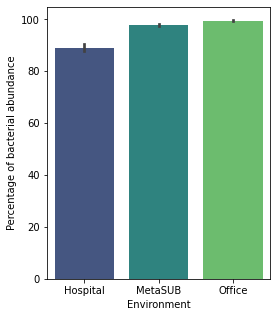

In [12]:
# Bar Plot
# add distribution plot
plt.figure(figsize=(4, 5))
sns.barplot(x='Environment', y='Sum Bacteria Abundance', data=aggregated_df, order=sorted(aggregated_df['Environment'].unique()), #errorbar="sd", 
            palette='viridis')
plt.xlabel('Environment')
plt.ylabel('Percentage of bacterial abundance')
plt.savefig(figure_path + 'Fig_2A.svg', format='svg')
plt.show()

In [13]:
# Filter data for only bacteria
bacteria_data = merged_data[merged_data['Major_group'] == 'Bacteria']
bacteria_data

,SL336366,SL336368,SL343330,SL343331,SL343333,SL343334,SL343336,SL343337,SL343339,SL343341,...,WEE379,WEE380,WEE381,WEE382,WEE384,WEE385,WEE386,WEE387,WEE388,Major_group
Species,,,,,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,0.0,0.0,0.0,0.0,0.0,0.388,0.0,0.0,0.0,0.0,...,0.000,0.0,0.578,0.0,0.129,0.777,0.518,0.0,0.0,Bacteria
Acetobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter piechaudii,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.132,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter xylosoxidans,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthomonas citri,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,2.800,0.000,0.000,0.0,0.0,Bacteria
Xanthomonas euvesicatoria,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.354,0.000,0.000,0.0,0.0,Bacteria
Xanthomonas fuscans,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,7.748,0.000,0.000,0.0,0.0,Bacteria


In [14]:
# Load updated names from a CSV file
updated_names = pd.read_csv(input_path + 'Updated_names.csv', sep=",")

# Convert DataFrame to dictionary
updated_name_dict = updated_names.set_index('Previous name')['Updated name'].to_dict()

# Replace the index names using the updated names dictionary
bacteria_data.index = bacteria_data.index.to_series().replace(updated_name_dict)
bacteria_data.drop(columns=["Major_group"], axis=1)
bacteria_data = bacteria_data.groupby(bacteria_data.index).sum()

bacteria_data

,SL336366,SL336368,SL343330,SL343331,SL343333,SL343334,SL343336,SL343337,SL343339,SL343341,...,WEE378,WEE379,WEE380,WEE381,WEE382,WEE384,WEE385,WEE386,WEE387,WEE388
Species,,,,,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,0.0,0.0,0.0,0.0,0.0,0.388,0.0,0.0,0.0,0.0,...,17.724,0.000,0.0,0.578,0.0,0.129,0.777,0.518,0.0,0.0
Acetobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0
Achromobacter piechaudii,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.132,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0
Achromobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0
Achromobacter xylosoxidans,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthomonas oryzae,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0
Xanthomonas vasicola,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,1.897,0.000,0.000,0.0,0.0
[Ruminococcus] torques,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.000,0.225,0.000,0.0,0.0


In [16]:
# Function to get taxonomic information for a given bacteria name
def get_taxonomic_info(bacteria_name):
    try:
        ncbi = NCBITaxa()
        taxid_mapping = ncbi.get_name_translator([bacteria_name])

        if not taxid_mapping:
            return {"Taxonomic_ID": "not found"}

        tax_id = taxid_mapping[bacteria_name][0]
        lineage = ncbi.get_lineage(tax_id)
        ranks = ncbi.get_rank(lineage)
        names = ncbi.get_taxid_translator(lineage)

        result = {"Taxonomic_ID": tax_id}
        result.update({ranks[tid]: names[tid] for tid in lineage})

        return result

    except Exception as e:
        return {"Error": str(e)}

In [17]:
# Apply the function to create a new column 'Taxonomic_Info'
bacteria_data["Taxonomic_Info"] = bacteria_data.index.map(get_taxonomic_info)
result_df = pd.json_normalize(bacteria_data["Taxonomic_Info"]).fillna("not found")
result_df.index = bacteria_data.index
result_df

,Taxonomic_ID,no rank,superkingdom,clade,phylum,class,order,family,genus,species,species group,species subgroup,suborder,strain,subclass,tribe,subspecies
Species,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,46125,cellular organisms,Bacteria,Terrabacteria group,Bacillota,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Abiotrophia defectiva,not found,not found,not found,not found,not found,not found,not found
Acetobacter unclassified,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found
Achromobacter piechaudii,72556,cellular organisms,Bacteria,not found,Pseudomonadota,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Achromobacter piechaudii,not found,not found,not found,not found,not found,not found,not found
Achromobacter unclassified,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found
Achromobacter xylosoxidans,85698,cellular organisms,Bacteria,not found,Pseudomonadota,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Achromobacter xylosoxidans,not found,not found,not found,not found,not found,not found,not found
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthomonas oryzae,347,cellular organisms,Bacteria,not found,Pseudomonadota,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas oryzae,not found,not found,not found,not found,not found,not found,not found
Xanthomonas vasicola,56459,cellular organisms,Bacteria,not found,Pseudomonadota,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas vasicola,not found,not found,not found,not found,not found,not found,not found
[Ruminococcus] torques,33039,cellular organisms,Bacteria,Terrabacteria group,Bacillota,Clostridia,Eubacteriales,Lachnospiraceae,Mediterraneibacter,[Ruminococcus] torques,not found,not found,not found,not found,not found,not found,not found


In [19]:
# Filter taxa table for only valid taxonomic IDs
filtered_taxa_table = result_df[result_df['Taxonomic_ID'] != 'not found']
filtered_taxa_table

# Filter samples data based on valid taxonomic IDs
filtered_samples_data = bacteria_data.loc[bacteria_data.index.isin(filtered_taxa_table.index)]
filtered_samples_data = filtered_samples_data.drop(columns=["Taxonomic_Info"], axis=1)
filtered_samples_data = filtered_samples_data / 100
filtered_samples_data

# Filter metadata based on valid samples
metadata_filtered = metadata.loc[metadata.index.isin(filtered_samples_data.columns)]
metadata_filtered

# Save filtered data, taxa, and metadata to CSV files
filtered_samples_data.to_csv(output_path + "phyloseq_source/all_filtered_data.csv", index=True, sep=',')
filtered_taxa_table.to_csv(output_path + "phyloseq_source/all_filtered_taxa.csv", index=True, sep=',')
metadata_filtered.to_csv(output_path + "phyloseq_source/all_filtered_metadata.csv", index=True, sep=',')

In [20]:
# Process and save data, taxa, and metadata for each environment
df_dict, taxa_dict, metadata_dict = {}, {}, {}
for env in metadata["Environment"].unique():
    sample_list = metadata[metadata["Environment"] == env].index.to_list()
    subset_df = filtered_samples_data[filtered_samples_data.columns[filtered_samples_data.columns.isin(sample_list)]]

    # Keep only non-zero rows
    subset_df = subset_df[(subset_df.sum(axis=1)) != 0]
    subset_df = subset_df.loc[:, (subset_df.sum(axis=0) != 0)]

    # Keep rows with a count of non-zero entries greater than the threshold (10% of the total number of samples)
    subset_df = subset_df[(subset_df > 0).sum(axis=1) >= (0.1 * len(subset_df.columns))]

    # Keep rows with relative abundance greater than 1%
    subset_df = subset_df[(subset_df >= .01).any(axis=1)]

    taxa_df = filtered_taxa_table.loc[filtered_taxa_table.index.isin(subset_df.index)]
    metadata_df = metadata.loc[metadata.index.isin(subset_df.columns)]
    df_dict[env] = subset_df
    taxa_dict[env] = taxa_df
    metadata_dict[env] = metadata_df

    subset_df.to_csv(f"{output_path}phyloseq_source/{env}_filtered_data.csv", index=True, sep=',')
    taxa_df.to_csv(f"{output_path}phyloseq_source/{env}_filtered_taxa.csv", index=True, sep=',')
    metadata_df.to_csv(f"{output_path}phyloseq_source/{env}_filtered_metadata.csv", index=True, sep=',')

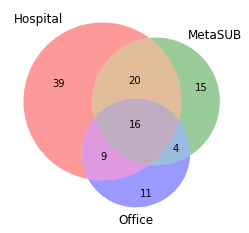

In [21]:
# Get the sets of taxa for the Venn diagram
taxa_sets = {key: set(value.index) for key, value in taxa_dict.items()}
venn3([taxa_sets['Hospital'], taxa_sets['MetaSUB'], taxa_sets['Office']], set_labels=['Hospital', 'MetaSUB', 'Office'])

# Save the plot
plt.savefig(figure_path + 'Supp_Fig_1A.svg', format='svg')
plt.show()

<ipython-input-22-33bda5815078>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_taxa_binary.loc[values, key] = 1
<ipython-input-22-33bda5815078>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_taxa_binary.loc[values, key] = 1
<ipython-input-22-33bda5815078>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_taxa_binary.loc[values, key] = 1


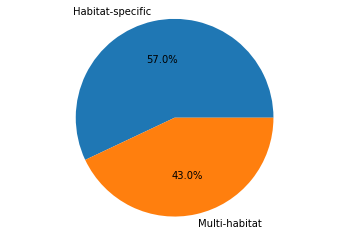

In [22]:
#Check the pie chart without the cutoffs, before filtering

# Create a list of all unique values from taxa_sets
unique_values = sorted(list(set().union(*taxa_sets.values())))

# Create an empty DataFrame with unique values as index and keys as columns
df_taxa_binary = pd.DataFrame(0, index=unique_values, columns=sorted(taxa_sets.keys()))

# Fill the DataFrame with 1 for present values
for key, values in taxa_sets.items():
    df_taxa_binary.loc[values, key] = 1

df_taxa_binary.to_csv(output_path + 'taxa_binary.csv', index=True, sep=',')
df_taxa_binary

# Calculate the row sum of the DataFrame
row_sum = df_taxa_binary.sum(axis=1)

# Classify index values as habitat-specific or multi-habitat
classification = ['Habitat-specific' if val == 1 else 'Multi-habitat' for val in row_sum]

# Count the number of occurrences for each classification
classification_counts = pd.Series(classification).value_counts()

# Create a pie chart
plt.pie(classification_counts, labels=classification_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.savefig(figure_path + 'Supp_Fig_1B.svg', format='svg')
plt.show()

In [23]:
# Fetching genome details of type strains of the selected microorganisms from the NCBI FTP link

# FTP link
ftp_link = "https://ftp.ncbi.nlm.nih.gov/genomes/refseq/assembly_summary_refseq.txt"


def fetch_row_by_organism_name(ftp_link, organism_name):
    """
    Fetches the row from the FTP link that contains the given organism name.

    Parameters:
    ftp_link (str): The FTP link to the file.
    organism_name (str): The name of the organism to search for.

    Returns:
    str: The row containing the organism name, or None if not found.
    """
    # Fetch the content of the file
    response = requests.get(ftp_link)
    if response.status_code == 200:
        # Split content by lines
        lines = response.text.split('\n')
        # Search for the row containing the organism name
        for line in lines:
            if "assembly from type material" in line or "assembly from synonym type material" in line:
                if organism_name in line:
                    return line    
            elif "assembly designated as neotype" in line:
                if organism_name in line:
                    return line         
            elif organism_name in line:
                return line
    else:
        print("Failed to fetch data from FTP link.")

# Create an empty DataFrame
column_names = ["assembly_accession", "bioproject", "biosample", "wgs_master", "refseq_category",
                "taxid", "species_taxid", "organism_name", "infraspecific_name", "isolate",
                "version_status", "assembly_level", "release_type", "genome_rep", "seq_rel_date",
                "asm_name", "asm_submitter", "gbrs_paired_asm", "paired_asm_comp", "ftp_path",
                "excluded_from_refseq", "relation_to_type_material", "asm_not_live_date", "assembly_type",
                "group", "genome_size", "genome_size_ungapped", "gc_percent", "replicon_count",
                "scaffold_count", "contig_count", "annotation_provider", "annotation_name",
                "annotation_date", "total_gene_count", "protein_coding_gene_count", "non_coding_gene_count",
                "pubmed_id"]

genome_details = pd.DataFrame(columns=column_names)

# Iterate over unique_values and append rows to the DataFrame
for organism_name in unique_values:
    row = fetch_row_by_organism_name(ftp_link, organism_name)
    if row:
        row_data = row.split('\t')
        genome_details = genome_details.append(pd.DataFrame([row_data], columns=column_names), ignore_index=True)

# Set organism_name as the index
genome_details.set_index('organism_name', inplace=True)

# Save the genome information to the CSV file
genome_details.to_csv(output_path + 'genome_details.csv', index=True, sep=',')

genome_details

<ipython-input-23-07b80738841d>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  genome_details = genome_details.append(pd.DataFrame([row_data], columns=column_names), ignore_index=True)
<ipython-input-23-07b80738841d>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  genome_details = genome_details.append(pd.DataFrame([row_data], columns=column_names), ignore_index=True)
<ipython-input-23-07b80738841d>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  genome_details = genome_details.append(pd.DataFrame([row_data], columns=column_names), ignore_index=True)
<ipython-input-23-07b80738841d>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,assembly_accession,bioproject,biosample,wgs_master,refseq_category,taxid,species_taxid,infraspecific_name,isolate,version_status,...,replicon_count,scaffold_count,contig_count,annotation_provider,annotation_name,annotation_date,total_gene_count,protein_coding_gene_count,non_coding_gene_count,pubmed_id
organism_name,,,,,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,GCF_963545605.1,PRJNA224116,SAMEA114449071,CAUUJW000000000.1,na,46125,46125,na,SRR13061535_bin.6_MetaWRAP_v1.3_MAG,latest,...,0,36,36,NCBI RefSeq,NCBI Prokaryotic Genome Annotation Pipeline (P...,2023/10/04,1887,1855,14,na
Achromobacter xylosoxidans,GCF_016728825.1,PRJNA224116,SAMN16357260,na,representative genome,85698,85698,strain=FDAARGOS_1091,na,latest,...,2,2,2,NCBI RefSeq,NCBI Prokaryotic Genome Annotation Pipeline (P...,2023/10/11,6445,6330,73,na
Acinetobacter baumannii,GCF_016745555.1,PRJNA224116,SAMN17349194,JAESEY000000000.1,na,470,470,strain=45875,na,latest,...,0,61,61,NCBI RefSeq,NCBI Prokaryotic Genome Annotation Pipeline (P...,2023/12/03,3770,3608,70,na
Acinetobacter johnsonii,GCF_009823385.1,PRJNA224116,SAMN12773519,VYQG00000000.1,na,40214,40214,strain=JH7,na,latest,...,0,78,78,NCBI RefSeq,NCBI Prokaryotic Genome Annotation Pipeline (P...,2023/12/30,3315,3137,85,na
Acinetobacter junii NIPH 182,GCF_000368745.1,PRJNA224116,SAMN01828162,APPW00000000.1,na,1217665,40215,strain=NIPH 182,na,latest,...,0,9,14,NCBI RefSeq,NCBI Prokaryotic Genome Annotation Pipeline (P...,2023/12/24,3175,3051,98,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stutzerimonas stutzeri KOS6,GCF_000307775.2,PRJNA224116,SAMN02470828,AMCZ00000000.2,na,1218352,316,strain=KOS6,na,latest,...,0,5,91,NCBI RefSeq,NCBI Prokaryotic Genome Annotation Pipeline (P...,2024/02/03,4598,4442,62,23405317
Veillonella atypica KON,GCF_000318355.2,PRJNA224116,SAMN02436795,AMEX00000000.1,na,1128111,39777,strain=KON,na,latest,...,0,40,67,NCBI RefSeq,NCBI Prokaryotic Genome Annotation Pipeline (P...,2023/05/18,1907,1840,46,na
Veillonella parvula HSIVP1,GCF_000448705.1,PRJNA224116,SAMN02471223,ASKE00000000.1,na,1316254,29466,strain=HSIVP1,na,latest,...,1,1,27,NCBI RefSeq,NCBI Prokaryotic Genome Annotation Pipeline (P...,2023/07/07,2049,1912,55,24309734
